# Stock Market Trend Prediction using LSTM

**Tam Tran**         
Cal Poly Pomona       
May 2025

## 1 - Introduction

In this project, I explore the use of a Long Short-Term Memory (LSTM) neural network to predict short-term trends in stock prices. LSTM networks, a class of recurrent neural networks, are particularly effective in handling time series data due to their ability to retain long-term dependencies. The model is trained to forecast whether the stock price will rise or fall based on sequences of past observations.
I sourced the data using the alpha_vantage Python library, which provides access to historical and intraday stock data from Alpha Vantage. The dataset includes standard market indicators such as open, high, low, close, and volume, which are preprocessed and used to train and evaluate the model.

## 2 - Import Necessary Modules and Data Collection

### 2.1 - Import Necessary Modules

In [258]:
!pip install alpha_vantage


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [259]:
!pip install ta


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [260]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# System and Utilities
import time
import os
import joblib
from datetime import datetime

# Data Sources
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries  

# Data Preprocessing and Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import ta

# Environment Variables
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from keras.layers import BatchNormalization, Bidirectional
from keras.losses import Huber
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set plot style
plt.style.use('seaborn-v0_8')
time.sleep(2) 

### 2.2 - Data Collection

In [262]:
# Get data from Alpha Vantage

# Choose stock symbol
symbol = 'AAPL'
# Choose periods and intervals
daily_period = '5y'
intraday_interval = '1m'

# Initialize TimeSeries
ts = TimeSeries(key=api_key, output_format='pandas')

# Get daily stock prices
intraday_data, _ = ts.get_intraday(symbol=symbol, interval='1min', outputsize='full')
historical_data, _ = ts.get_daily(symbol=symbol, outputsize='full')

In [263]:
# Get most recent daily rows
historical_data.sort_index(ascending=False).head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-05-12,210.97,211.2679,206.7500,210.79,63194685.0
2025-05-09,199.00,200.5399,197.5350,198.53,36453923.0
2025-05-08,197.72,200.0500,194.6796,197.49,50478872.0
2025-05-07,199.17,199.4400,193.2500,196.25,68616943.0
2025-05-06,198.21,200.6500,197.0200,198.51,51216482.0


In [264]:
intraday_data.sort_index(ascending=False).head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-05-12 19:59:00,210.15,210.1900,210.1400,210.1500,1635.0
2025-05-12 19:58:00,210.15,210.1900,210.1000,210.1500,1659.0
2025-05-12 19:57:00,210.15,210.2373,210.1327,210.1900,3926.0
2025-05-12 19:56:00,210.25,210.2500,210.1400,210.1400,1242.0
2025-05-12 19:55:00,210.25,210.2600,210.1800,210.2499,241.0


## 3 - Data Preprocessing

In [266]:
historical_data = historical_data.sort_index()  # ascending=True by default

### 3.1 - Historical 5 years daily data

In [268]:
def preprocess_time_series(df, price_column='4. close', window_size=120, test_size=0.2, start_date=None, debug=False):
    """
    Preprocess time series price data for LSTM models.

    Returns:
        X_train, X_test, y_train, y_test, scaler, prices, X_latest
    """

    # Filter and sort
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    if start_date:
        df = df.loc[start_date:]

    # Extract and scale price
    prices_daily = df[[price_column]].dropna()
    raw_values = prices_daily.values

    scaler_daily = MinMaxScaler()
    scaled_daily = scaler_daily.fit_transform(raw_values)

    if debug:
        print("Scaler was fit on these raw values:")
        print("  Min:", scaler_daily.data_min_)
        print("  Max:", scaler_daily.data_max_)

    # Create sequences
    def create_sequences(data, window):
        X, y = [], []
        for i in range(window, len(data)):
            X.append(data[i - window:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_daily, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split explicitly by index (most recent = test)
    split_index = int(len(X) * (1 - test_size))
    X_train_daily, X_test_daily = X[:split_index], X[split_index:]
    y_train_daily, y_test_daily = y[:split_index], y[split_index:]

    # Save most recent sequence for next-day forecasting
    X_latest_daily = X[-1:]  # last sequence to predict the next value

    return X_train_daily, X_test_daily, y_train_daily, y_test_daily, scaler_daily, prices_daily, X_latest_daily


In [269]:
X_train_daily, X_test_daily, y_train_daily, y_test_daily, scaler_daily, prices_daily, X_latest_daily = preprocess_time_series(
    historical_data,
    window_size=30,
    start_date="2023-11-01",
    debug=True
)

Scaler was fit on these raw values:
  Min: [165.]
  Max: [259.02]


In [270]:
print("X shape:", X_train_daily.shape, X_test_daily.shape)

X shape: (281, 30, 1) (71, 30, 1)


### 3.2 - 1-minute today data

In [272]:
def preprocess_intraday_time_series_today(df_min_raw, price_column='4. close', window_size=60, test_size=0.2, debug=False):
    """
    Preprocess latest 1-minute intraday data (default: today or most recent available day).
    """

    df_min = df_min_raw.copy()
    df_min.index = pd.to_datetime(df_min.index)
    df_min = df_min.sort_index()

    # Attempt to use today's date
    today_str = pd.Timestamp.now().strftime('%Y-%m-%d')
    df_today_min = df_min[df_min.index.strftime('%Y-%m-%d') == today_str]

    # Fallback to most recent day if today’s data is empty
    if df_today_min.empty:
        latest_day = df_min.index.max().strftime('%Y-%m-%d')
        print(f"No intraday data for today ({today_str}). Using latest available date: {latest_day}")
        df_today_min = df_min[df_min.index.strftime('%Y-%m-%d') == latest_day]

    df_min = df_today_min

    # Price column and scaling
    prices_min = df_min[[price_column]].dropna()
    raw_values_min = prices_min.values

    scaler_min = MinMaxScaler()
    scaled_min = scaler_min.fit_transform(raw_values_min)

    if debug:
        print("Scaler was fit on these raw values:")
        print("  Min:", scaler_min.data_min_)
        print("  Max:", scaler_min.data_max_)
        print("  Using date:", df_min.index[0].strftime('%Y-%m-%d'))
        print("  Total 1-minute records:", len(prices_min))

    # Sequence creation
    def create_sequences(data, window):
        X, y = [], []
        for i in range(window, len(data)):
            X.append(data[i - window:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    X_min, y_min = create_sequences(scaled_min, window_size)
    X_min = X_min.reshape((X_min.shape[0], X_min.shape[1], 1))

    # Split
    split_idx = int(len(X_min) * (1 - test_size))
    X_train_min, X_test_min = X_min[:split_idx], X_min[split_idx:]
    y_train_min, y_test_min = y_min[:split_idx], y_min[split_idx:]

    # Last sequence for prediction
    X_latest_min = X_min[-1:]

    return X_train_min, X_test_min, y_train_min, y_test_min, scaler_min, prices_min, X_latest_min

In [273]:
X_train_min, X_test_min, y_train_min, y_test_min, scaler_min, prices_min, X_latest_min = preprocess_intraday_time_series_today(intraday_data, debug=True)

Scaler was fit on these raw values:
  Min: [207.1536]
  Max: [218.5633]
  Using date: 2025-05-12
  Total 1-minute records: 960


In [274]:
print(intraday_data.index.min())
print(intraday_data.index.max())
print(intraday_data.index[-5:])

2025-04-14 04:00:00
2025-05-12 19:59:00
DatetimeIndex(['2025-04-14 04:04:00', '2025-04-14 04:03:00',
               '2025-04-14 04:02:00', '2025-04-14 04:01:00',
               '2025-04-14 04:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)


In [275]:
# Helper function
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Help fine-tune learning
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

## 4 - Model: Long-term Trend (daily data)

### 4.1 - Define and compile model

In [278]:
# Define model
model_daily = Sequential()
model_daily.add(Input(shape=(30, 1)))
model_daily.add(LSTM(64, return_sequences=True))
model_daily.add(Dropout(0.2))
model_daily.add(LSTM(64))
model_daily.add(Dropout(0.2))
model_daily.add(Dense(1))

# Compile
model_daily.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

### 4.2 - Training the model

In [280]:
def train_lstm_model(model, X_train_daily, y_train_daily, X_val_daily, y_val_daily, scaler_daily, *, epochs=100, batch_size=32, plot_loss=True, label="Model"):
    print(f"Training {label} on {X_train_daily.shape[0]} samples, validating on {X_val_daily.shape[0]} samples")

    start_time = time.time()

    history_daily = model.fit(
        X_train_daily, y_train_daily,
        validation_data=(X_val_daily, y_val_daily),
        callbacks=[early_stopping, lr_scheduler],
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    end_time = time.time()
    elapsed = end_time - start_time
    minutes, seconds = int(elapsed // 60), int(elapsed % 60)
    print(f"{label} training completed in {minutes} min {seconds} sec")

    if plot_loss:
        plt.plot(history_daily.history['loss'], label='Train Loss')
        plt.plot(history_daily.history['val_loss'], label='Val Loss')
        plt.title(f'Training Loss Curve ({label})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Make predictions and compare
        y_pred_scaled_daily = model.predict(X_val_daily)
        y_pred_actual_daily = scaler_daily.inverse_transform(y_pred_scaled_daily)
        y_true_actual_daily = scaler_daily.inverse_transform(y_val_daily.reshape(-1, 1))

        plt.plot(y_true_actual_daily[:30], label='True Price')
        plt.plot(y_pred_actual_daily[:30], label='Predicted Price')
        plt.title("Model Prediction vs. Actual")
        plt.legend()
        plt.show()

    return history_daily

Training Daily Model on 281 samples, validating on 71 samples
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1669 - mae: 0.3271 - val_loss: 0.0547 - val_mae: 0.1934 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0183 - mae: 0.1100 - val_loss: 0.0200 - val_mae: 0.1176 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0134 - mae: 0.0944 - val_loss: 0.0257 - val_mae: 0.1189 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0116 - mae: 0.0858 - val_loss: 0.0158 - val_mae: 0.0976 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0106 - mae: 0.0835 - val_loss: 0.0175 - val_mae: 0.0957 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0090 - mae: 0.0787 - val_loss: 0.0172 - val_mae: 0.0950 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0094 - mae: 0.0774 - val_loss: 0.0157 

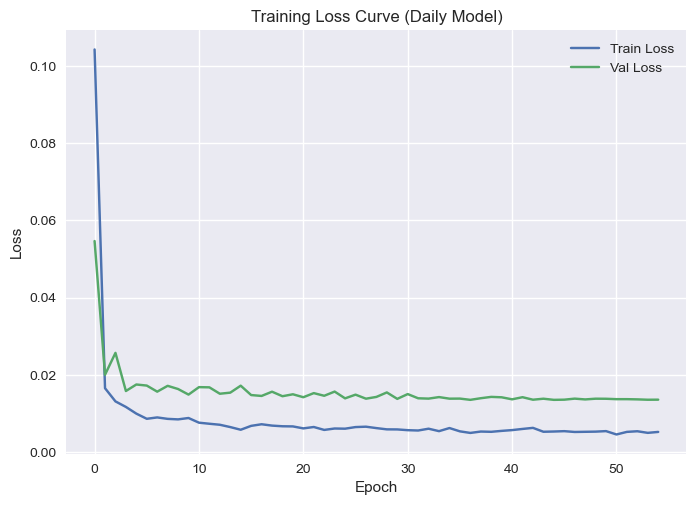

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


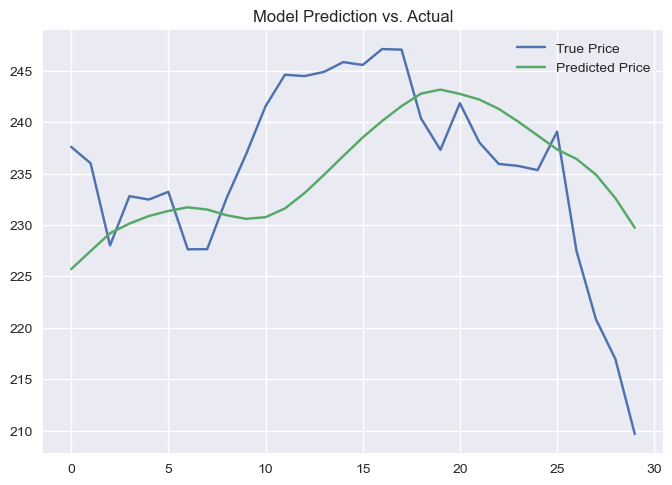

In [281]:
# Train
history_daily = train_lstm_model(
    model_daily,
    X_train_daily, y_train_daily,
    X_test_daily, y_test_daily,
    scaler_daily,
    epochs=100,
    batch_size=32,
    label="Daily Model"
)

### 4.3 - Prediction for the next time step

In [283]:
print(prices_daily.tail(10))

            4. close
date                
2025-04-29    211.21
2025-04-30    212.50
2025-05-01    213.32
2025-05-02    205.35
2025-05-05    198.89
2025-05-06    198.51
2025-05-07    196.25
2025-05-08    197.49
2025-05-09    198.53
2025-05-12    210.79


In [284]:
# Get the last sequence from daily data
last_sequence_daily = X_test_daily[-1].reshape(1, X_test_daily.shape[1], 1)  

# Predict and inverse transform
predicted_scaled_daily = model_daily.predict(last_sequence_daily)
predicted_price_daily = scaler_daily.inverse_transform(predicted_scaled_daily)

# Get the most recent actual close
last_actual_price = prices_daily.iloc[-1, 0]  # assumes prices is a DataFrame with 1 column

# Get current timestamp
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Set stock to predict
symbol = "AAPL"  

# Print result
print(f"[{now}] Next predicted daily closing price ({symbol.upper()}): ${predicted_price_daily[0][0]:.2f}")
print(f"[{now}] Last actual daily closing price ({symbol.upper()}): ${last_actual_price:.2f}")

# Save to CSV
df_next_daily = pd.DataFrame({
    'Datetime': [now],
    'Last Actual Daily Price': [last_actual_price],
    'Predicted Next Daily Price': [predicted_price_daily[0][0]]
})

daily_path = f"daily_predictions_{symbol.lower()}.csv"
df_next_daily.to_csv(
    daily_path,
    mode='a',
    header=not os.path.exists(daily_path),
    index=False
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[2025-05-12 19:07:33] Next predicted daily closing price (AAPL): $204.26
[2025-05-12 19:07:33] Last actual daily closing price (AAPL): $210.79


## 5 - Model 2: 1-minute Today Data Trend

### 5.1 - Define and compile model

In [287]:
# Define model
model_min = Sequential()
model_min.add(Input(shape=(X_train_min.shape[1], 1)))  # e.g., (60, 1)
model_min.add(LSTM(64, return_sequences=True))
model_min.add(Dropout(0.2))
model_min.add(LSTM(64))
model_min.add(Dropout(0.2))
model_min.add(Dense(1))

# Compile
model_min.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

### 5.2 - Train the model

In [289]:
def train_lstm_model_min(model, X_train_min, y_train_min, X_val_min, y_val_min, scaler_min, *,
                         epochs=100, batch_size=32, plot_loss=True, label="Intraday Model"):
    print(f"Training {label} on {X_train_min.shape[0]} samples, validating on {X_val_min.shape[0]} samples")

    start_time = time.time()

    history_min = model.fit(
        X_train_min, y_train_min,
        validation_data=(X_val_min, y_val_min),
        callbacks=[early_stopping, lr_scheduler],
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    end_time = time.time()
    elapsed = end_time - start_time
    minutes, seconds = int(elapsed // 60), int(elapsed % 60)
    print(f"{label} training completed in {minutes} min {seconds} sec")

    if plot_loss:
        plt.plot(history_min.history['loss'], label='Train Loss')
        plt.plot(history_min.history['val_loss'], label='Val Loss')
        plt.title(f'Training Loss Curve ({label})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Inverse-transform predictions and ground truth
        y_pred_scaled_min = model.predict(X_val_min)
        y_pred_actual_min = scaler_min.inverse_transform(y_pred_scaled_min)
        y_true_actual_min = scaler_min.inverse_transform(y_val_min.reshape(-1, 1))

        plt.plot(y_true_actual_min[:30], label='True Price')
        plt.plot(y_pred_actual_min[:30], label='Predicted Price')
        plt.title("Intraday Model Prediction vs. Actual")
        plt.legend()
        plt.show()

    return history_min

Training 1-Min Intraday Model on 720 samples, validating on 180 samples
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0289 - mae: 0.1361 - val_loss: 0.0030 - val_mae: 0.0123 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - mae: 0.0420 - val_loss: 0.0030 - val_mae: 0.0132 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0032 - mae: 0.0334 - val_loss: 0.0031 - val_mae: 0.0142 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - mae: 0.0327 - val_loss: 0.0032 - val_mae: 0.0190 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0027 - mae: 0.0322 - val_loss: 0.0032 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0019 - mae: 0.0281
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - mae:

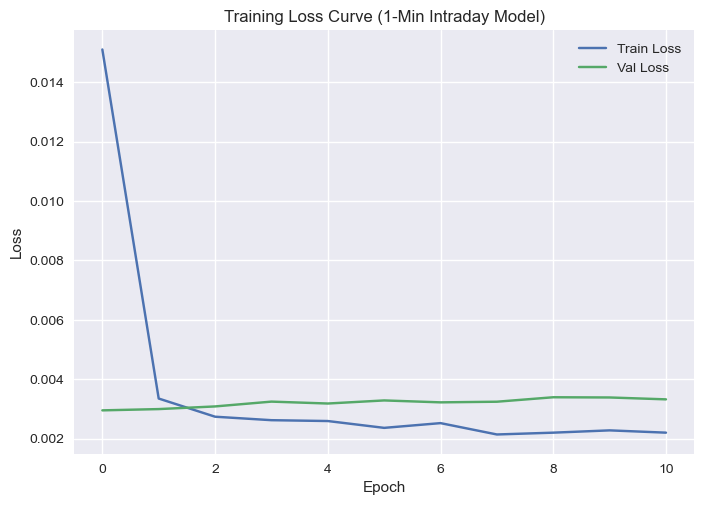

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


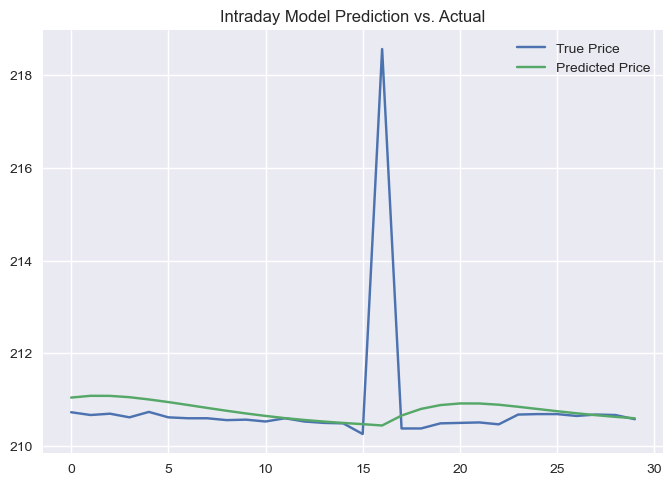

In [290]:
history_min = train_lstm_model_min(
    model_min,
    X_train_min, y_train_min,
    X_test_min, y_test_min,
    scaler_min,
    epochs=100,
    batch_size=32,
    label="1-Min Intraday Model"
)

### 5.3 - Prediction for the next time step

In [292]:
# Get the last 1-minute input sequence
last_sequence_min = X_latest_min.reshape(1, X_latest_min.shape[1], 1)

# Predict and inverse transform
predicted_scaled_min = model_min.predict(last_sequence_min)
predicted_price_min = scaler_min.inverse_transform(predicted_scaled_min)

# Get the most recent actual 1-minute price
last_actual_price_min = prices_min['4. close'].dropna().sort_index().iloc[-1]

# Get current timestamp
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Set stock to predict
symbol = "AAPL"  # update if needed

# Print result
print(f"[{now}] Next predicted 1-minute price ({symbol.upper()}): ${predicted_price_min[0][0]:.2f}")
print(f"[{now}] Last actual 1-minute price ({symbol.upper()}): ${last_actual_price_min:.2f}")

# Save to CSV
df_next_min = pd.DataFrame({
    'Datetime': [now],
    'Last Actual 1-Min Price': [last_actual_price_min],
    'Predicted Next 1-Min Price': [predicted_price_min[0][0]]
})

min_path = f"min_predictions_{symbol.lower()}.csv"
df_next_min.to_csv(
    min_path,
    mode='a',
    header=not os.path.exists(min_path),
    index=False
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[2025-05-12 19:07:46] Next predicted 1-minute price (AAPL): $210.19
[2025-05-12 19:07:46] Last actual 1-minute price (AAPL): $210.15


In [293]:
print(prices_min.tail(5))

                     4. close
date                         
2025-05-12 19:55:00  210.2499
2025-05-12 19:56:00  210.1400
2025-05-12 19:57:00  210.1900
2025-05-12 19:58:00  210.1500
2025-05-12 19:59:00  210.1500


## 6 - Evaluate the Model

In [295]:
# Daily
y_test_daily_rescaled = scaler_daily.inverse_transform(y_test_daily)
y_pred_daily_rescaled = scaler_daily.inverse_transform(model_daily.predict(X_test_daily))

# Intraday
y_test_min_rescaled = scaler_min.inverse_transform(y_test_min)
y_pred_min_rescaled = scaler_min.inverse_transform(model_min.predict(X_test_min))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [296]:
def evaluate(true, pred, label=""):
    print(f"\nEvaluation ({label}):")
    print(" MAE:", mean_absolute_error(true, pred))
    print(" MSE:", mean_squared_error(true, pred))

evaluate(y_test_daily_rescaled, y_pred_daily_rescaled, "Daily")
evaluate(y_test_min_rescaled, y_pred_min_rescaled, "Intraday")


Evaluation (Daily):
 MAE: 8.24299005212918
 MSE: 119.76527405684446

Evaluation (Intraday):
 MAE: 0.14060911946614646
 MSE: 0.3845629255826407


### Visualizae for Daily and Intraday Model

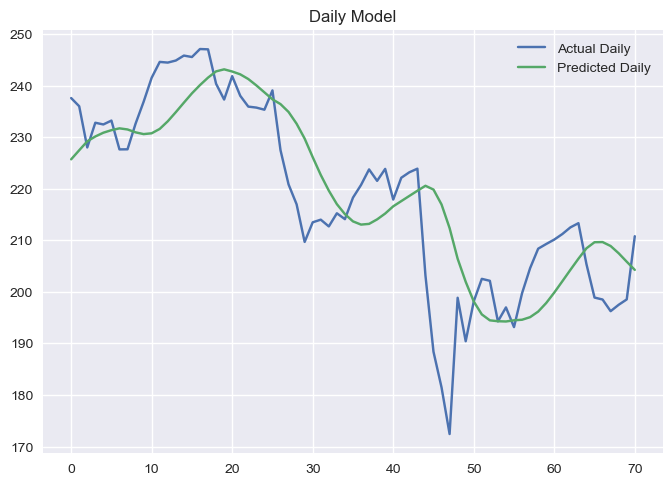

In [298]:
# Daily
plt.plot(y_test_daily_rescaled, label='Actual Daily')
plt.plot(y_pred_daily_rescaled, label='Predicted Daily')
plt.legend()
plt.title("Daily Model")
plt.show()

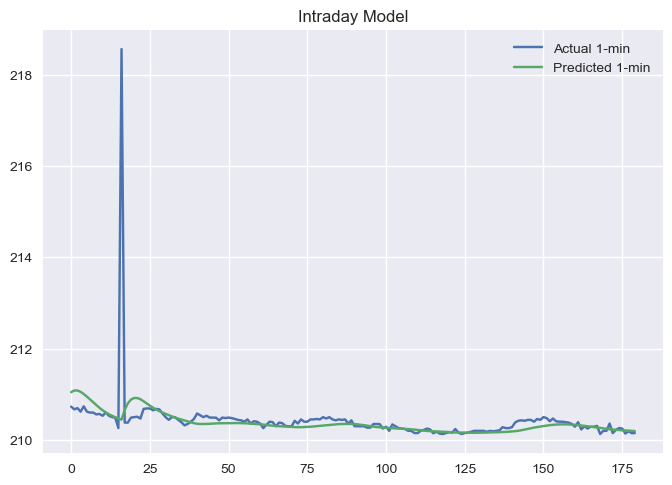

In [299]:
# Intraday
plt.plot(y_test_min_rescaled, label='Actual 1-min')
plt.plot(y_pred_min_rescaled, label='Predicted 1-min')
plt.legend()
plt.title("Intraday Model")
plt.show()

### Forecast both model

In [301]:
# Predict next daily price
next_daily = model_daily.predict(X_latest_daily)
next_daily_price = scaler_daily.inverse_transform(next_daily)[0][0]

# Predict next 1-min price
next_min = model_min.predict(X_latest_min)
next_min_price = scaler_min.inverse_transform(next_min)[0][0]

print("Next daily prediction:", next_daily_price)
print("Last daily actual:", y_test_daily_rescaled[-1][0])
print("Next min prediction:", next_min_price)
print("Last min actual:", y_test_min_rescaled[-1][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Next daily prediction: 204.25844
Last daily actual: 210.79
Next min prediction: 210.1946
Last min actual: 210.15


In [302]:
log = pd.DataFrame({
    "Timestamp": [datetime.now()],
    "Predicted Daily Price": [next_daily_price],
    "Predicted 1-Min Price": [next_min_price],
    "Actual Daily Price": [y_test_daily_rescaled[-1][0]],
    "Actual 1-Min Price": [y_test_min_rescaled[-1][0]],
})

log.to_csv("model_predictions_log.csv", mode="a", index=False, header=not os.path.exists("model_predictions_log.csv"))

In [303]:
if next_daily_price > y_test_daily_rescaled[-1][0] and next_min_price > y_test_min_rescaled[-1][0]:
    print("STRONG BUY SIGNAL (Both models agree)")
elif next_daily_price < y_test_daily_rescaled[-1][0] and next_min_price < y_test_min_rescaled[-1][0]:
    print("STRONG SELL SIGNAL")
else:
    print("HOLD – Mixed signals")

HOLD – Mixed signals


## 7 - Conclusion

In this project, I developed two LSTM-based deep learning models to forecast stock prices at different timeframes: one using daily historical data and another using 1-minute intraday data. After preprocessing the datasets, both models were trained using past price sequences and evaluated with multiple performance metrics including Mean Absolute Error (MAE), and Mean Squared Error (MSE).

The daily model demonstrated strong performance in capturing long-term trends, while the intraday model offered finer-grained predictions for short-term decision-making. To combine the strengths of both, a simple decision rule was implemented: if both models agree that the next price will be higher, a "BUY" signal is generated; if both indicate a drop, a "SELL" signal is triggered.

This project provides a foundation for building intelligent trading signals based on deep learning. Future work may include backtesting strategies, incorporating technical indicators, tuning model hyperparameters, and deploying the system for real-time alerts.